In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from utils_db import load_table
from preprocess import drop_nan_df, format_num_df, format_str_df, analyze_df

pd.set_option("display.max_columns", None)

In [2]:
# load table
df_raw = load_table("cars")
df_raw.head()

,car_id,url,brand,model,price,post_code,prod_year,mileage,gearbox,energy,attrs,crawled_at
0,1,https://www.lacentrale.fr/auto-occasion-annonc...,CITROEN,CITROEN C5 AIRCROSS,17 900 €,91380,2021,58 440 km,Automatique,Diesel,"{'Couleur': 'Grey', 'Crit'Air': '', 'Longueur'...",2025-05-22 01:01:11.143096
1,2,https://www.lacentrale.fr/auto-occasion-annonc...,RENAULT,RENAULT ARKANA,14 900 €,91380,2021,97 730 km,Automatique,Hybride essence électrique,"{'Couleur': 'Black', 'Crit'Air': '', 'Longueur...",2025-05-22 01:02:14.256237
2,5,https://www.lacentrale.fr/auto-occasion-annonc...,PEUGEOT,PEUGEOT 308 III SW,15 990 €,78130,2022,125 185 km,Automatique,Diesel,"{'Couleur': 'Gris', 'Crit'Air': '', 'Longueur'...",2025-05-22 02:01:43.181004
3,6,https://www.lacentrale.fr/auto-occasion-annonc...,PEUGEOT,PEUGEOT 2008 II,14 900 €,91260,2020,62 285 km,Automatique,Essence,"{'Couleur': 'Orange', 'Crit'Air': '', 'Longueu...",2025-05-22 02:02:23.869099
4,7,https://www.lacentrale.fr/auto-occasion-annonc...,DACIA,DACIA LODGY phase 2,12 980 €,78711,2021,76 872 km,Manuelle,Diesel,"{'Couleur': 'Blanc', 'Crit'Air': '', 'Longueur...",2025-05-22 02:02:52.591344


In [3]:
def expand_df(df_raw: pd.DataFrame):
    # Expand attrs
    df_attrs = pd.json_normalize(df_raw["attrs"])
    df = pd.concat([df_raw.drop(columns=["attrs"]), df_attrs], axis=1)

    # Drop unwanted columns
    df.drop(columns=["car_id", "url", "crawled_at", "Crit'Air"], inplace=True)

    return df


df = expand_df(df_raw)
df = drop_nan_df(df)
df = format_num_df(df)
df = format_str_df(df)

df["Mise en circulation"] = pd.to_datetime(df["Mise en circulation"], format="%d/%m/%Y")
df["circulation_year"] = df["Mise en circulation"].dt.year
df.drop(columns=["Mise en circulation"], inplace=True)

df.head()

,brand,model,price,post_code,prod_year,mileage,gearbox,energy,Couleur,Longueur,Norme euro,Provenance,Puissance DIN,Première main,Emission de CO2,Nombre de places,Nombre de portes,Puissance fiscale,Contrôle technique,circulation_year
0,citroen,citroen c5 aircross,17900,91,2021,58440,automatique,diesel,grey,4.50,euro6,non renseignée,131,oui,138,5,5,7,non requis,2021
1,renault,renault arkana,14900,91,2021,97730,automatique,hybride essence électrique,black,4.57,euro6,non renseignée,145,oui,108,5,5,5,non requis,2021
2,peugeot,peugeot 308 iii sw,15990,78,2022,125185,automatique,diesel,gris,4.64,euro6,non renseignée,131,oui,122,5,5,7,non requis,2022
3,peugeot,peugeot 2008 ii,14900,91,2020,62285,automatique,essence,orange,4.30,euro6,non renseignée,130,oui,139,5,5,6,requis,2020
4,dacia,dacia lodgy phase 2,12980,78,2021,76872,manuelle,diesel,blanc,4.50,euro6,non renseignée,116,oui,125,5,5,6,requis,2021


In [4]:
analyze_df(df)


-- shape --

(1028, 20)

-- data type --

brand                  object
model                  object
price                   int64
post_code              object
prod_year               int64
mileage                 int64
gearbox                object
energy                 object
Couleur                object
Longueur              float64
Norme euro             object
Provenance             object
Puissance DIN           int64
Première main          object
Emission de CO2         int64
Nombre de places        int64
Nombre de portes        int64
Puissance fiscale       int64
Contrôle technique     object
circulation_year        int32
dtype: object

-- unique values count --

brand                  44
model                 468
price                 489
post_code              78
prod_year              26
mileage               960
gearbox                 2
energy                  8
Couleur               265
Longueur              143
Norme euro              5
Provenance              3
Pui

# Distribution

1. Extreme values in price. -> log transform.
2. Too many categories in model, post_code. -> TargetEncoder
3. Too many categories in energy, Couleur. -> Rare Encoding

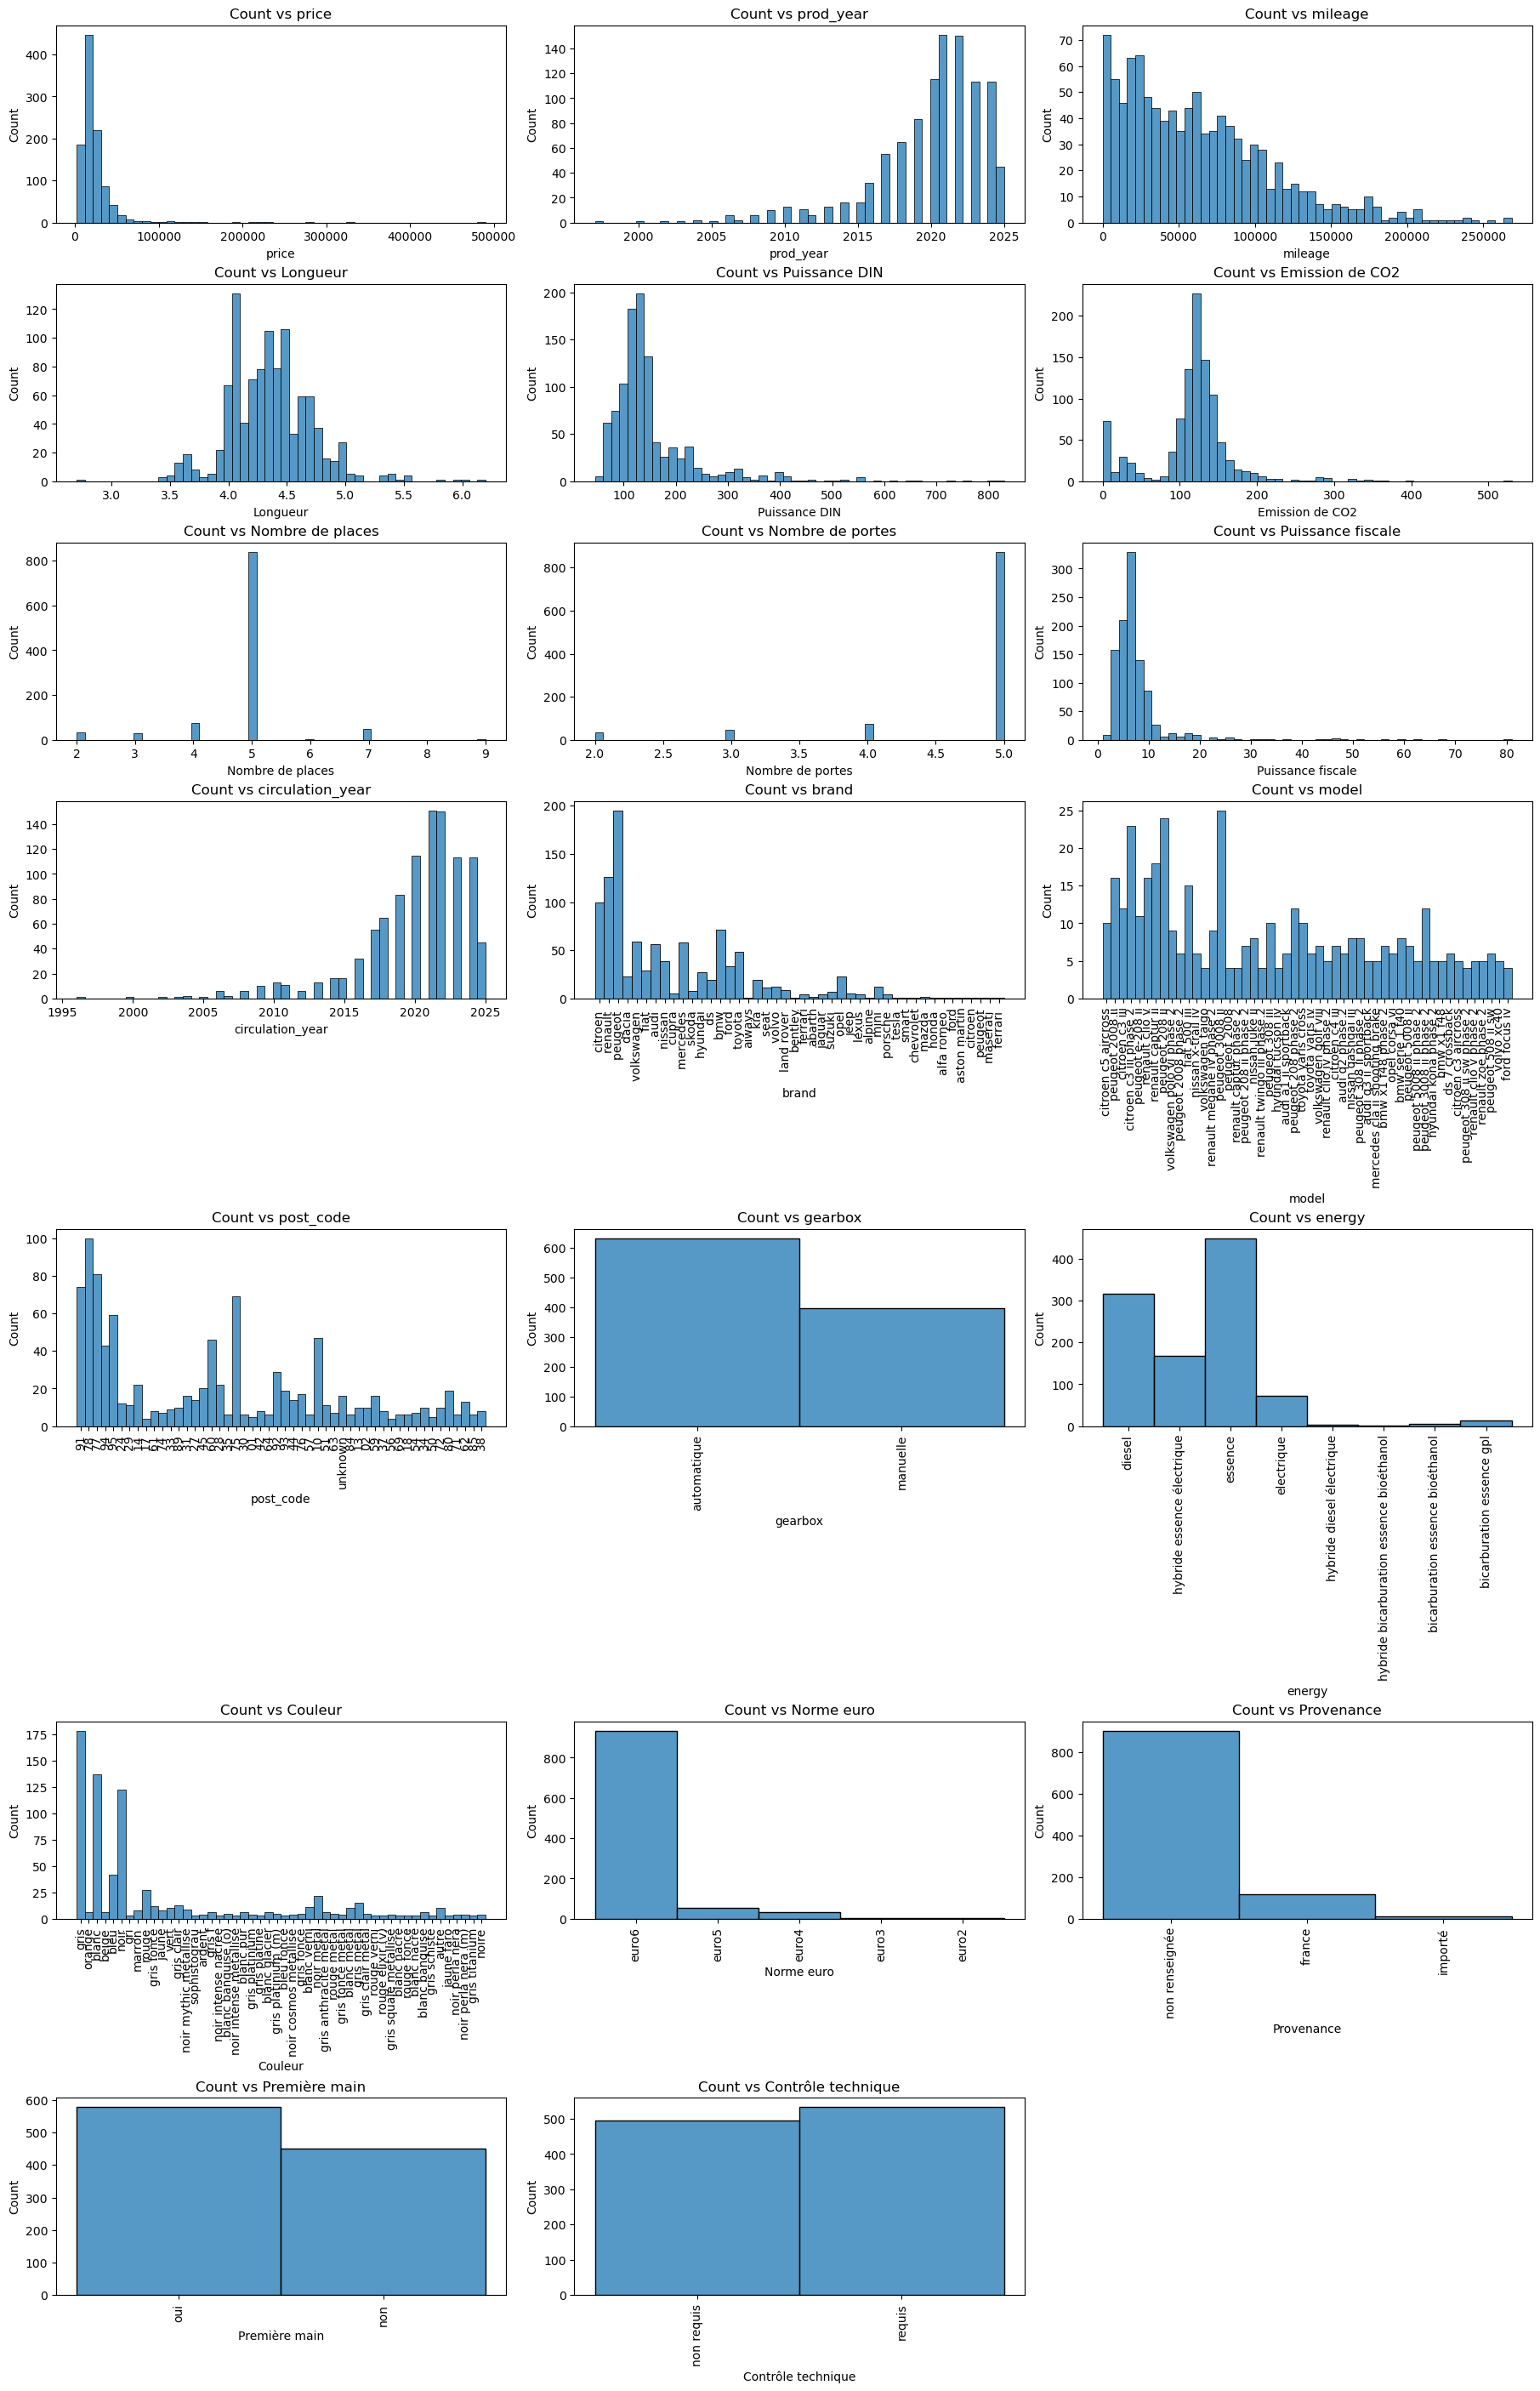

In [5]:
def plot_count_vs_features(df: pd.DataFrame):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    all_cols = numerical_cols + categorical_cols
    
    c = 3
    r = math.ceil(len(all_cols) / c)
    fig, axes = plt.subplots(r, c, figsize=(c * 6, r * 4), constrained_layout=True)
    axes = axes.flatten()
    topk = 50
    
    for i, col in enumerate(all_cols):
        ax = axes[i]
        
        if col in numerical_cols:
            sns.histplot(data=df, x=col, bins=50, ax=ax, kde=False)
        else:
            # Keep top frequent categories
            top_categories = df[col].value_counts().nlargest(topk).index.tolist()
            df_filtered = df[df[col].isin(top_categories)]
            sns.histplot(data=df_filtered, x=col, bins=50, ax=ax, kde=False)
            ax.tick_params(axis='x', labelrotation=90)
        ax.set_title(f"Count vs {col}")
    # Hide unused axes
    for j in range(len(all_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.savefig("results/count_vs_features.png")
    plt.show()


plot_count_vs_features(df)

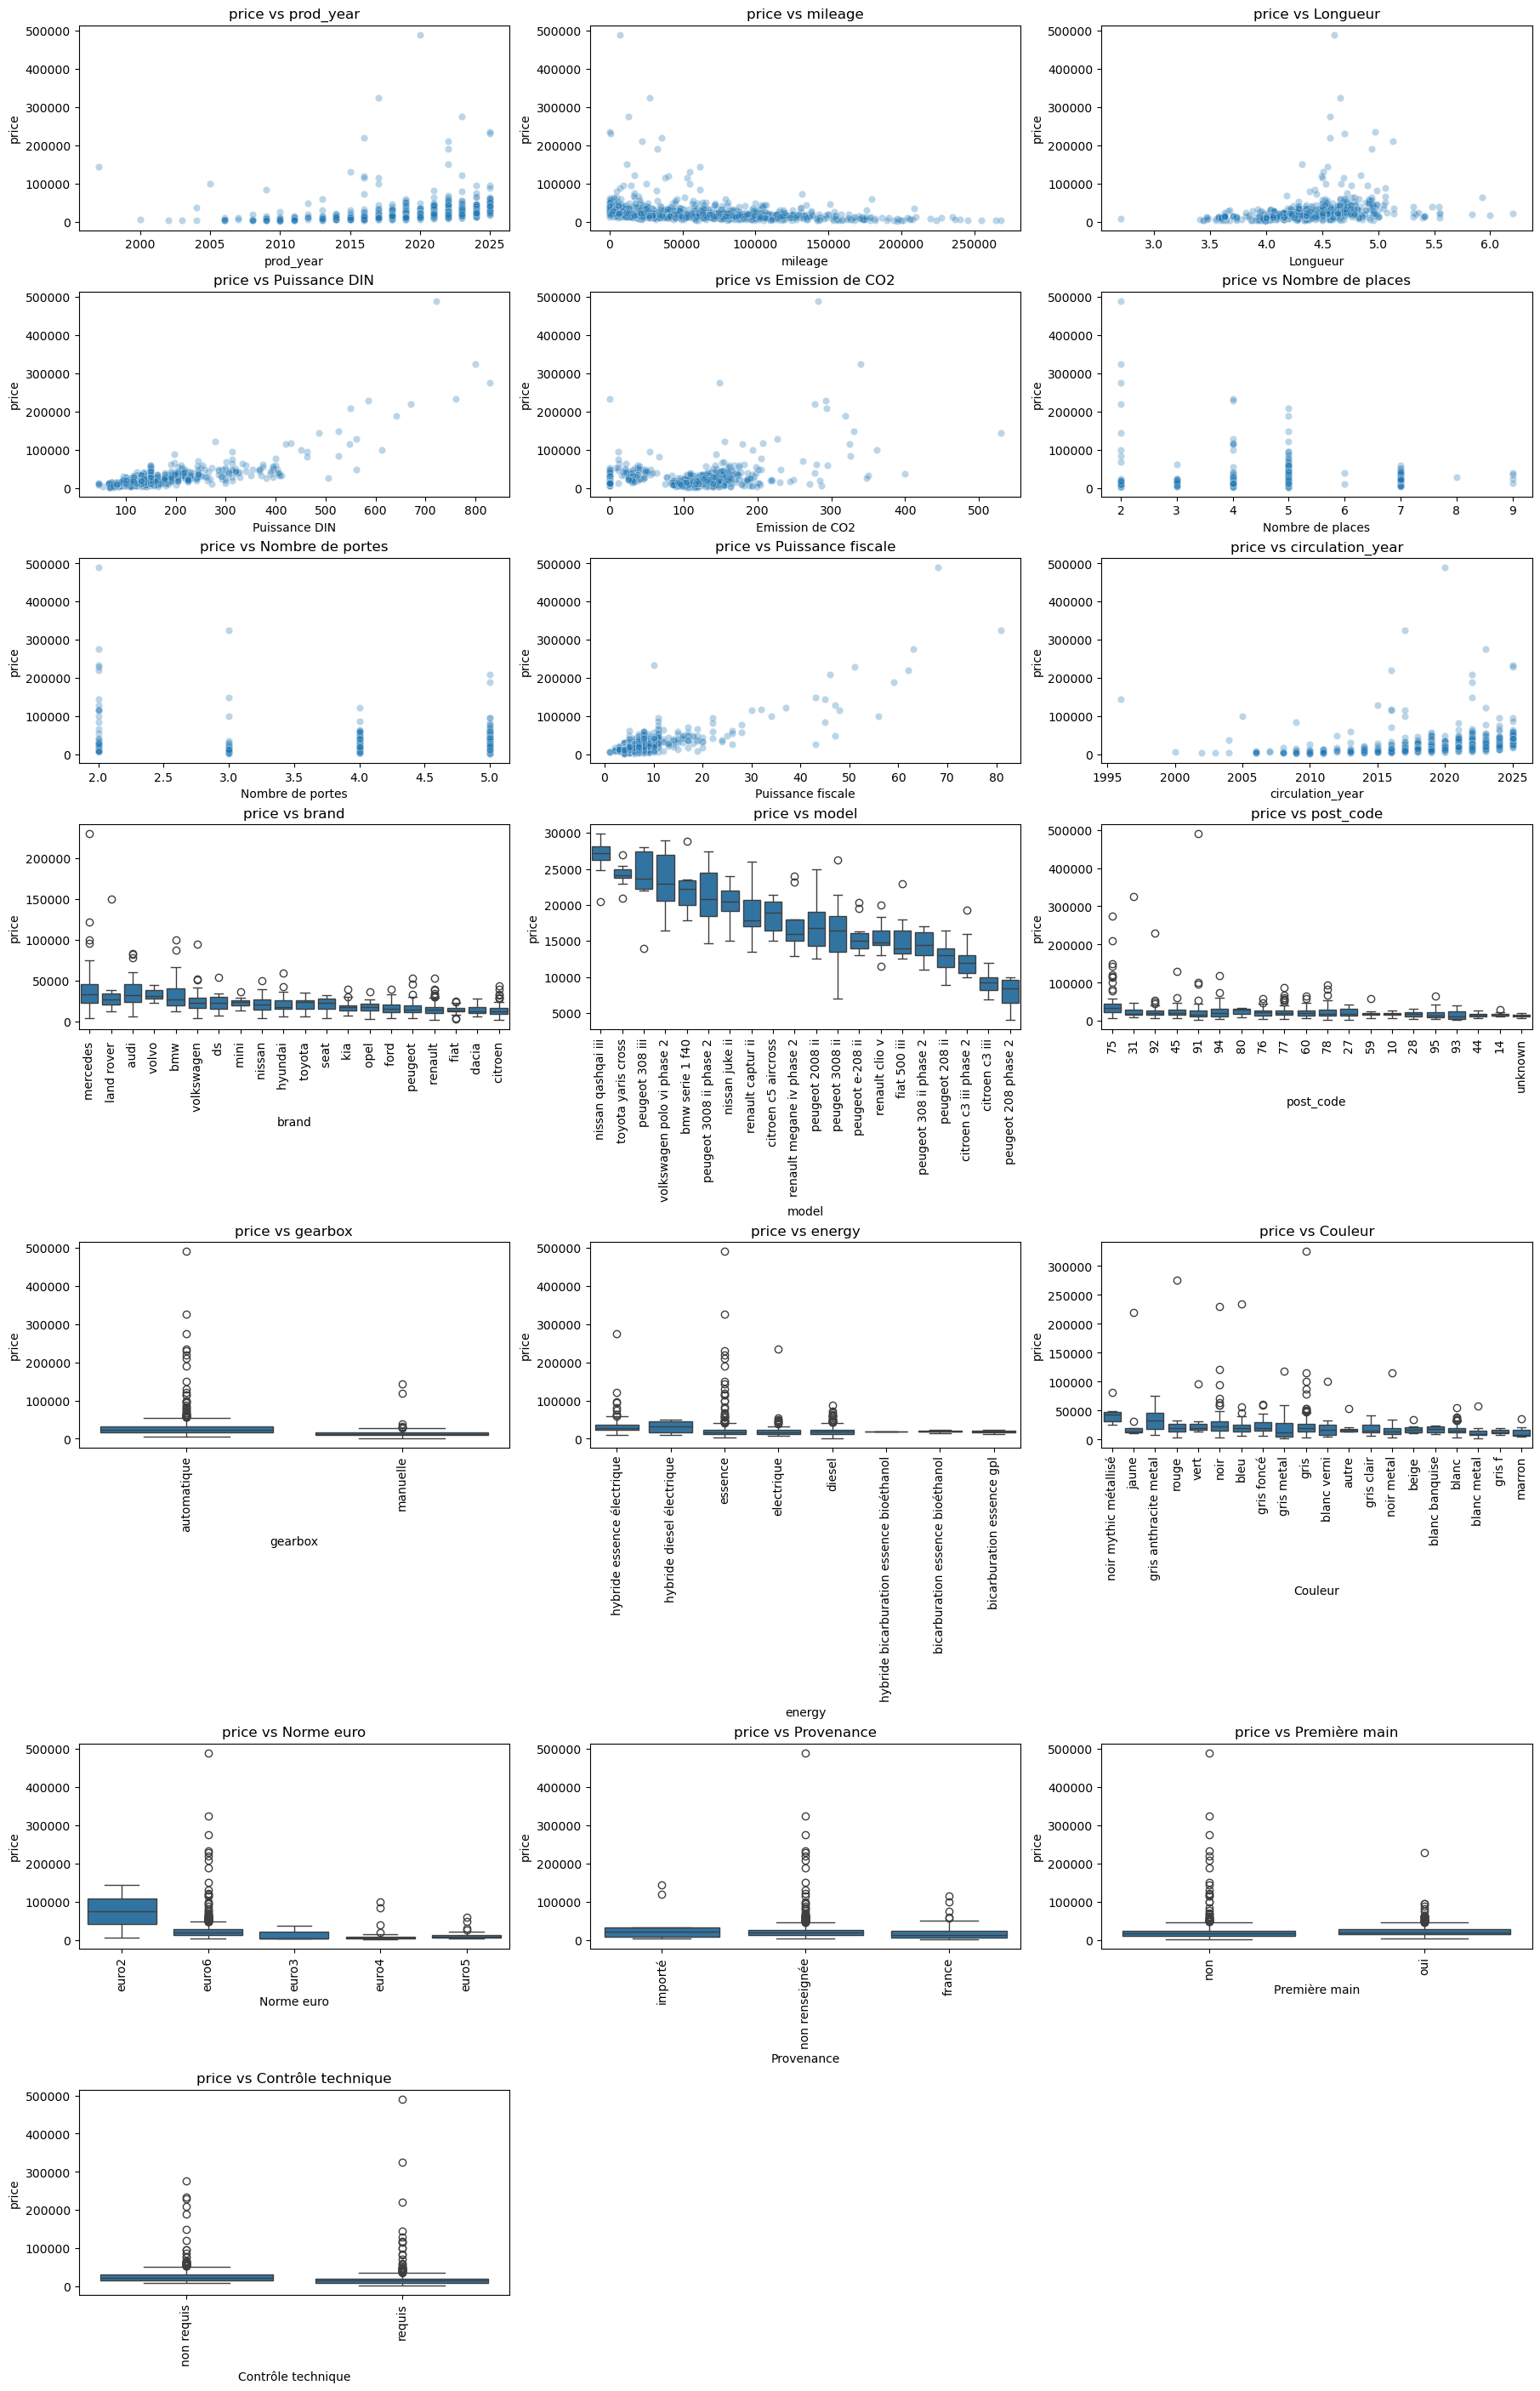

In [6]:
def plot_target_vs_features(df: pd.DataFrame, target: str):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    numerical_cols.remove(target)
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    all_cols = numerical_cols + categorical_cols
    
    c = 3
    r = math.ceil(len(all_cols) / c)
    fig, axes = plt.subplots(r, c, figsize=(c * 6, r * 4), constrained_layout=True)
    axes = axes.flatten()
    topk = 20
    
    for i, col in enumerate(all_cols):
        ax = axes[i]
        if col in numerical_cols:
            sns.scatterplot(data=df, x=col, y=target, ax=ax, alpha=0.3)
        else:
            # Keep top frequent categories
            top_categories = df[col].value_counts().nlargest(topk).index.tolist()
            df_filtered = df[df[col].isin(top_categories)]
            categories = (
                df_filtered.groupby(col)[target]
                .mean()
                .sort_values(ascending=False)
                .index
                .tolist()
            )
            sns.boxplot(data=df_filtered, x=col, y=target, ax=ax, order=categories)
            ax.tick_params(axis='x', labelrotation=90)
        ax.set_title(f"{target} vs {col}")
    # Hide unused axes
    for j in range(len(all_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.savefig("results/target_vs_features.png")
    plt.show()


plot_target_vs_features(df, target="price")

# Correlation

1. High correlated features with price.  
Puissance fiscale, Puissance DIN

3. Multicollinearity.  
('prod_year', 'circulation_year'), ('Puissance DIN', 'Puissance fiscale')


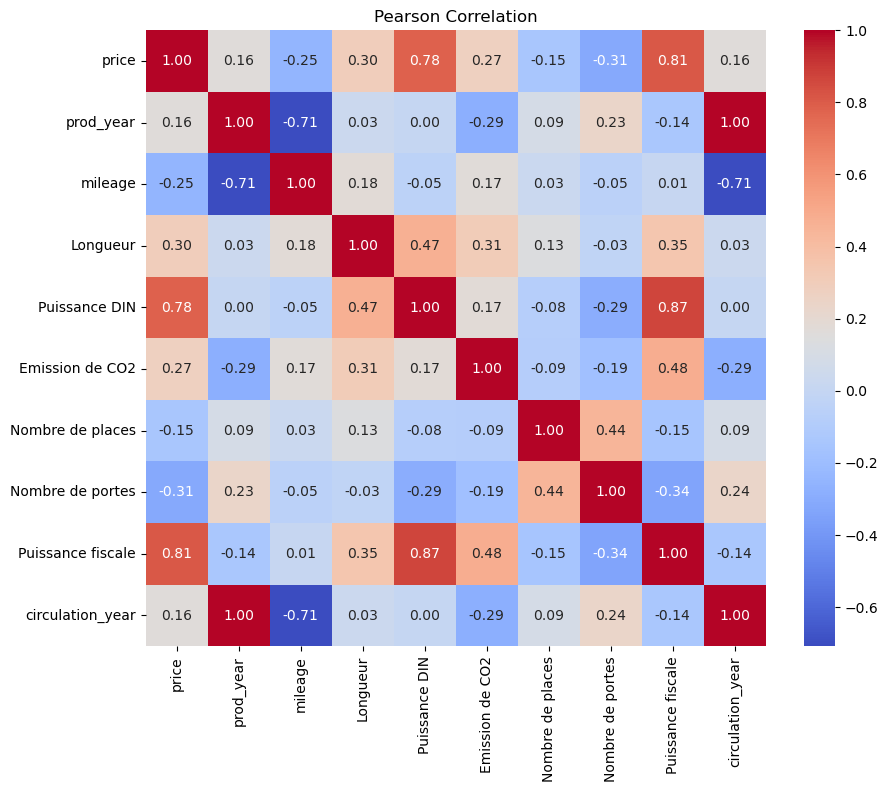

price                1.000000
Puissance fiscale    0.811762
Puissance DIN        0.782985
Nombre de portes     0.312829
Longueur             0.298770
Emission de CO2      0.274132
mileage              0.249021
prod_year            0.160883
circulation_year     0.159604
Nombre de places     0.145016
Name: price, dtype: float64


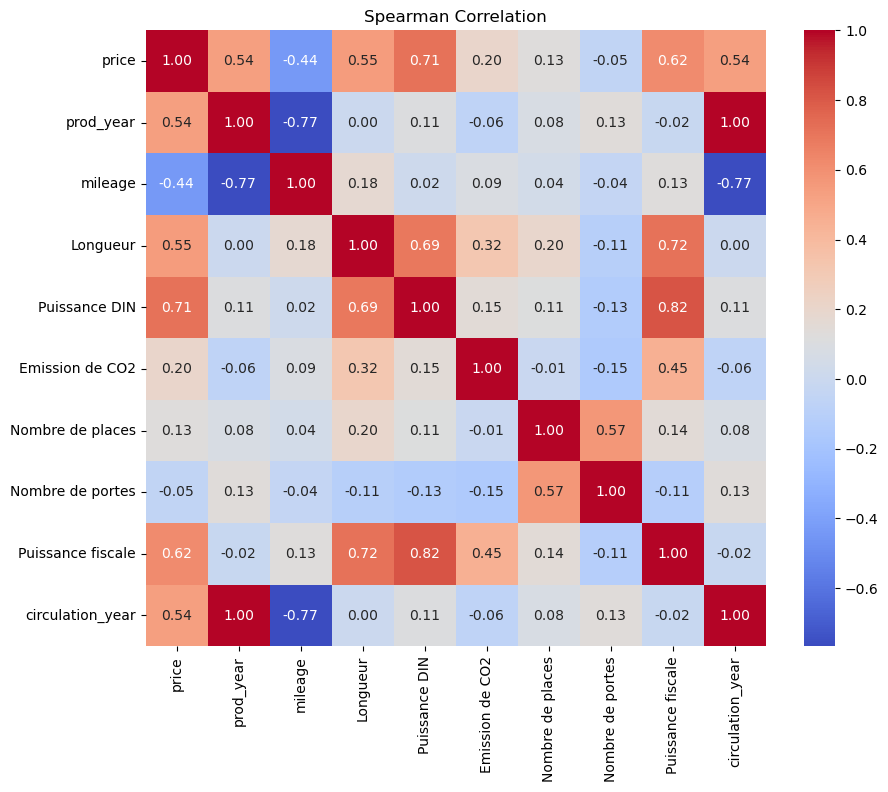

price                1.000000
Puissance DIN        0.714671
Puissance fiscale    0.616745
Longueur             0.548626
prod_year            0.537435
circulation_year     0.537435
mileage              0.440762
Emission de CO2      0.200868
Nombre de places     0.128686
Nombre de portes     0.051010
Name: price, dtype: float64


In [7]:
def plot_corr(df: pd.DataFrame, target: str | None = None, method: str = "pearson"):
    df_numerical = df.select_dtypes(include=['number'])
    corr_matrix = df_numerical.corr(method=method)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"{method} Correlation".title())
    plt.show()

    if target:
        target_corr = corr_matrix["price"].abs().sort_values(ascending=False)
        
        print(target_corr)


plot_corr(df, target="price", method="pearson")
plot_corr(df, target="price", method="spearman")

In [8]:
def compute_corr_pairs(df: pd.DataFrame, threshold=0.8):
    """
    Compute correlation pairs to address multicollinearity
    """
    df_numerical = df.select_dtypes(include=['number'])
    corr_matrix = df_numerical.corr()
    
    pairs = []
    cols = corr_matrix.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            col1, col2 = cols[i], cols[j]
            corr = corr_matrix.loc[col1, col2]
            if abs(corr) > threshold:
                pairs.append((col1, col2, float(corr)))
    pairs = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
    print("\n-- Correlation Pairs --\n")
    print(pairs)


compute_corr_pairs(df)


-- Correlation Pairs --

[('prod_year', 'circulation_year', 0.9999700923407008), ('Puissance DIN', 'Puissance fiscale', 0.8678589992687485), ('price', 'Puissance fiscale', 0.8117621638880667)]
